<a href="https://colab.research.google.com/github/mamoonmasud/graph_community/blob/main/GAT(GitHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
#Checking if cuda is available. If return False, change runtime to GPU
print(torch.cuda.is_available())

True


In [3]:
print(torch.version.cuda)

11.1


In [4]:
#Checking Python Version
! python --version

Python 3.7.12


In [5]:
# Installing DGL
! pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html 

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 165.0 MB 50 kB/s 


In [6]:
from google.colab import files

In [9]:
# Doing all the imports:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl.data import DGLDataset
from scipy import sparse as sp
from math import log
import pandas as pd
from sklearn import metrics as skmetrics
import pickle
import numpy as np
import os
import itertools

In [ ]:
#from dgl.nn.pytorch.conv import GATConv as GAT

In [35]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [36]:
upload_files()

Saving GAT.py to GAT.py
Saving performance.py to performance.py
Saving Sparsemax.py to Sparsemax.py


['GAT.py', 'performance.py', 'Sparsemax.py']

In [37]:
import GAT
import Sparsemax
import performance as pf


# Graph Neural Network Definition



In [38]:
class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = th.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = th.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')


In [39]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return th.cat(head_outs, dim=1)
        else:
            # merge using average
            return th.mean(torch.stack(head_outs))

In [40]:
class Net(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(Net, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        h = F.log_softmax(h, 1)
        return h

# Data Loading

In [107]:
# Generating a dgl graph from the given csv files of github dataset at: http://snap.stanford.edu/data/github-social.html

class GitHubDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='github_dataset')

    def process(self):
        nodes_data = pd.read_csv('drive/MyDrive/CSCE689/data_git/papers.csv')
        edges_data = pd.read_csv('drive/MyDrive/CSCE689/data_git/git_edges.csv')
        node_target = pd.read_csv('drive/MyDrive/CSCE689/data_git/musae_git_target.csv')
        node_features = torch.from_numpy(nodes_data.to_numpy())
        node_labels = torch.from_numpy(node_target["ml_target"].astype('category').cat.codes.to_numpy())
        #edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())
        edges_src = torch.from_numpy(edges_data['source'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['target'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        #self.graph.edata['weight'] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset = GitHubDataset()
graph = dataset[0]


In [108]:
num_class = 2

features = graph.ndata['feat']

train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
labels = graph.ndata['label']

# add self loop
#g.remove_edges_from(nx.selfloop_edges(g))
graph = dgl.remove_self_loop(graph)
#g = DGLGraph(g)
graph.add_edges(graph.nodes(), graph.nodes())

comb_mask = torch.zeros(len(train_mask), dtype=torch.bool)

for i in range(len(comb_mask)):
    if test_mask[i] or train_mask[i] or val_mask[i]:
        comb_mask[i] = True


In [111]:
features = features.float()

In [125]:
labels = labels.long()

In [16]:
print('We have %d nodes.' % graph.number_of_nodes())
print('We have %d edges.' % graph.number_of_edges())

We have 37700 nodes.
We have 326703 edges.


# Selecting Training Set

In [31]:
percentage_train = 0.6
percentage_val = 0.2

with open("drive/MyDrive/CSCE689/data_git/git_permutation4.pickle","rb") as f:
    perm1 = pickle.load(f)
mask_train = np.zeros(graph.number_of_nodes())
mask_val = np.zeros(graph.number_of_nodes())

i_train = int(percentage_train*graph.number_of_nodes())
i_val = i_train + int(percentage_val*graph.number_of_nodes())
mask_train[perm1[range(0,i_train)]] = 1
mask_val[perm1[range(i_train,i_val)]] = 1
mask_train = th.BoolTensor(mask_train)
mask_val = th.BoolTensor(mask_val)

In [32]:
g= graph

## Training

In [41]:
loss_function = pf.perm_inv_loss(labels)
import copy

In [127]:
import time

net = GAT.GAT_Net_fast(g=g, in_feats=features.shape[1], hidden_size=100, hidden_layers=2, out_feats=len(np.unique(labels)),
dropout=0.2, batchnorm=False, num_heads=1, residual = False)
#print(net)

optimizer = th.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-2)
net.train() # Set to training mode (use dropout)

dur = []
loss_ev = []
current_best = 0 #arbitrarily high
current_best_epoch = 0
current_best_params = None
no_improvement_for = 0

for epoch in range(1000):
    if epoch >=3:
        t0 = time.time()

    # Compute loss for test nodes (only for validation, not used by optimizer)
    net.eval()
    
    prediction = net(features)
    train_rand = pf.rand_score(labels[mask_train].numpy(),np.argmax(prediction[mask_train].detach().numpy(), axis=1))
    validation_rand = pf.rand_score(labels[mask_val].numpy(),np.argmax(prediction[mask_val].detach().numpy(), axis=1))
    if train_rand>current_best:
        current_best = train_rand
        current_best_epoch = epoch
        current_best_params = copy.deepcopy(net.state_dict())
        no_improvement_for = 0
    else: no_improvement_for += 1
    
    if no_improvement_for>50:
        break
    
    net.train()

    # Compute loss for train nodes
    logits = net(features)

    #loss = loss_function.approximate_loss(logits,mask_train,nclasses=7)
    loss = F.nll_loss(logits[mask_train], labels[mask_train])
    loss_ev.append(loss.detach().item())
    #print(np.unique(np.argmax(logits[mask_train].detach().numpy(),1)))
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) {np.mean(dur):.4f}")
    else:
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) unknown")
        
net.load_state_dict(current_best_params)

Epoch 00000 | Loss 2.1574 | Train.Rand 0.0244 | Valid.Rand 0.0301 | Time(s) unknown
Epoch 00001 | Loss 1.5081 | Train.Rand 0.0306 | Valid.Rand 0.0359 | Time(s) unknown
Epoch 00002 | Loss 1.0722 | Train.Rand 0.0035 | Valid.Rand 0.0170 | Time(s) unknown
Epoch 00003 | Loss 1.2732 | Train.Rand -0.0004 | Valid.Rand 0.0001 | Time(s) 1.6988
Epoch 00004 | Loss 1.3794 | Train.Rand 0.0002 | Valid.Rand -0.0006 | Time(s) 1.7021
Epoch 00005 | Loss 1.1344 | Train.Rand 0.0093 | Valid.Rand 0.0103 | Time(s) 1.7004
Epoch 00006 | Loss 0.9873 | Train.Rand 0.0116 | Valid.Rand 0.0170 | Time(s) 1.7034
Epoch 00007 | Loss 0.9455 | Train.Rand 0.0073 | Valid.Rand 0.0117 | Time(s) 1.7049
Epoch 00008 | Loss 0.8582 | Train.Rand 0.0050 | Valid.Rand 0.0100 | Time(s) 1.7022
Epoch 00009 | Loss 0.7704 | Train.Rand 0.0137 | Valid.Rand 0.0098 | Time(s) 1.7009
Epoch 00010 | Loss 0.8068 | Train.Rand 0.0082 | Valid.Rand 0.0027 | Time(s) 1.6989
Epoch 00011 | Loss 0.8074 | Train.Rand -0.0009 | Valid.Rand -0.0033 | Time(s) 1.69

<All keys matched successfully>

In [124]:
labels.

torch.int8

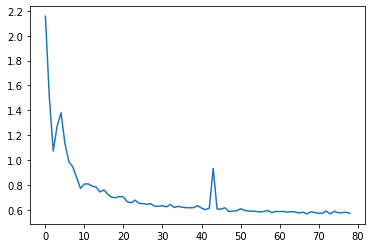

In [128]:
import seaborn as sns
sns.lineplot(x=range(len(loss_ev)), y=loss_ev)


In [129]:
net.load_state_dict(current_best_params)

<All keys matched successfully>

In [130]:
np.unique(np.argmax(logits[mask_train].detach().numpy(),1))

array([0, 1])

In [131]:
# Visualise predictions
net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = net(features).detach()
a = np.transpose(np.vstack([final_prediction[comb_mask].numpy().argmax(axis=1),labels[comb_mask].numpy()]))
a[a[:,0].argsort()][np.random.choice(range(a.shape[0]),size=10)]

# As can be seen, the graph net predicts correct labels

array([[0, 0],
       [0, 0],
       [0, 1],
       [0, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1]])

In [132]:
import matplotlib.pyplot as plt


dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(G, **options)


Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


NameError: ignored

<Figure size 1080x504 with 0 Axes>

## Evaluation


In [133]:
# Performnace evaluation functions

def variation_of_information_score(labels, preds):
    def mi(x, y):
        contingency = skmetrics.cluster.contingency_matrix(x, y, sparse=True)
        # print(contingency.todense())
        nzx, nzy, nz_val = sp.find(contingency)
        contingency_sum = contingency.sum()

        pi = np.ravel(contingency.sum(axis=1))
        pj = np.ravel(contingency.sum(axis=0))
        # print(nz_val)
        log_contingency_nm = np.log(nz_val)
        # print(log_contingency_nm)
        contingency_nm = nz_val / contingency_sum
        # print(contingency_nm)

        # Don't need to calculate the full outer product, just for non-zeroes
        outer = pi.take(nzx).astype(np.int64, copy=False) * pj.take(nzy).astype(
            np.int64, copy=False
        )
        # print(outer)
        log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())
        # print(log_outer)
        mi = (
            contingency_nm * (log_contingency_nm - log(contingency_sum))
            + contingency_nm * log_outer
        )
        # print(mi)
        return mi.sum()

    return mi(labels, labels) + mi(preds, preds) - 2 * mi(labels, preds)


def mutual_info_score(labels, preds):
    return skmetrics.adjusted_mutual_info_score(labels, preds, average_method="arithmetic")

def compute_performance(labels, logits, splits):
    logits = logits.detach().numpy()
    preds = np.argmax(logits, axis=1)
    labels = labels.numpy()
    pred_sets = {
        "All ": preds,
        "Train": preds[mask_train],
        "Val": preds[mask_val],
        "Test": preds[test_mask],
    }
    label_sets = {
        "All ": labels,
        "Train": labels[mask_train],
        "Val": labels[mask_val],
        "Test": labels[test_mask],
    }
    eval_functions = {
        "Rand-Index": rand_score,
        "Mutual Information": mutual_info_score,
        "Variation of Information": variation_of_information_score,
    }
    scores = {
        subset: {
            name: func(label_sets[subset], pred_sets[subset])
            for name, func in eval_functions.items()
        }
        for subset in pred_sets.keys()
    }
    return scores

def performance_as_df(labels, logits, splits):
    scores = compute_performance(labels, logits, splits)
    return pd.DataFrame(scores)

def rand_score(labels, preds):
    return skmetrics.adjusted_rand_score(labels, preds)

In [134]:
net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = net(features).detach()
performance_as_df(labels,final_prediction,comb_mask)

,All,Train,Val,Test
Rand-Index,0.081777,0.083345,0.076261,0.073702
Mutual Information,0.022555,0.022489,0.021113,0.018171
Variation of Information,0.908057,0.905504,0.917646,1.075580
